<a href="https://colab.research.google.com/github/seirah-yang/BootCamp/blob/main/%EB%AA%A8%EB%8D%B8%EC%B5%9C%EC%A0%81%ED%99%94%EC%99%80_%EC%BB%A8%EB%B2%84%ED%8A%B8_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 추론 가속화 (TensorRT)

In [1]:
import torch
print("PyTorch 버전:", torch.__version__)

PyTorch 버전: 2.8.0+cu126


In [2]:
!pip install torch_tensorrt==2.5.0

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 813.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 665.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch_tensorrt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

batch_size = 128
learning_rate = 0.001
num_epochs = 10

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Training model...")
model.train()
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img.view(-1, 28*28))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#-- 학습 끝

# 가짜 랜덤 이미지 만들어서 추론 속도 측정해볼거임.
sample_input = torch.randn(batch_size, 1, 28, 28).to(device)
#-- 랜덤 이미지 한개 만들어

# 속도측정함수
def measure_inference_time(model, input_data, num_runs=100):
    model.eval()
    with torch.no_grad():
        for _ in range(10): # 첫번째 반복문은 스탠바이 테스트/(inferance)예열단계
            _ = model(input_data)

        start_time = time.time() # 스탠바이 테스트 하고서 시간 측정 >>시작
        for _ in range(num_runs): # 실제 데이터 주입.
            _ = model(input_data)
        end_time = time.time() # 시간 측정 끝<<
    total_time = end_time - start_time
    avg_time = total_time / num_runs
    return avg_time

# tensor RT 적용 안한거 시간 출력
print("Measuring PyTorch model inference time...")
pytorch_time = measure_inference_time(model, sample_input)
print(f"PyTorch average inference time: {pytorch_time:.6f} seconds")

#===============================================================

# Torch-TensorRT 변환
print("Converting to Torch-TensorRT...")
model.eval()  # 모델을 평가 모드로 전환하여 학습 중 업데이트 방지
trt_model = torch_tensorrt.compile(model,
    inputs=[torch_tensorrt.Input(
        min_shape=[1, 1, 28, 28],   # 최소 입력 크기: 모델이 최소한으로 처리할 수 있는 입력 크기 지정(오류 방지)
        opt_shape=[batch_size, 1, 28, 28],  # 최적 입력 크기: 최적의 성능을 내도록 추천하는 입력 크기
        max_shape=[batch_size, 1, 28, 28],  # 최대 입력 크기: 메모리 관리 및 안정성을 위해 허용되는 최대 입력 크기 지정
        dtype=torch.float32)],  # 입력 데이터 타입
    enabled_precisions={torch.float32}, # 32비트 연산을 사용해 정확성을 유지 (fp16 등은 정밀도 손실 위험이 있음)
    workspace_size=1 << 30   # 비트연산자. 2의30승=1GB GPU 메모리 할당. 빌드 시 최적화를 위해 1GB 메모리를 할당, 시스템 자원 한계 고려
)

print("Measuring Torch-TensorRT model inference time...")
trt_time = measure_inference_time(trt_model, sample_input)
print(f"Torch-TensorRT average inference time: {trt_time:.6f} seconds")

speedup = pytorch_time / trt_time if trt_time > 0 else float('inf')
print(f"\nSpeed comparison:")
print(f"PyTorch time: {pytorch_time:.6f} seconds")
print(f"Torch-TensorRT time: {trt_time:.6f} seconds")
print(f"Speedup (PyTorch / TRT): {speedup:.2f}x")


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 517kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.98MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.26MB/s]


Training model...
Epoch [1/10], Loss: 0.0392
Epoch [2/10], Loss: 0.0304
Epoch [3/10], Loss: 0.0248
Epoch [4/10], Loss: 0.0248
Epoch [5/10], Loss: 0.0218
Epoch [6/10], Loss: 0.0214
Epoch [7/10], Loss: 0.0192
Epoch [8/10], Loss: 0.0178
Epoch [9/10], Loss: 0.0188
Epoch [10/10], Loss: 0.0149
Measuring PyTorch model inference time...
PyTorch average inference time: 0.000283 seconds
Converting to Torch-TensorRT...
Measuring Torch-TensorRT model inference time...
Torch-TensorRT average inference time: 0.000196 seconds

Speed comparison:
PyTorch time: 0.000283 seconds
Torch-TensorRT time: 0.000196 seconds
Speedup (PyTorch / TRT): 1.45x


# 경량화(프루닝)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.prune as prune # 토치 프레임워크에서 프루닝 지원함.
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 하이퍼파라미터 설정
batch_size = 64
learning_rate = 0.01
epochs = 1
prune_amount = 0.3  # 프루닝 비율

# 데이터 전처리 정의
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 데이터 로드
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# 모델, 손실 함수, 옵티마이저 초기화
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# 학습 함수
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 100 == 99:
            print(f'Epoch {epoch} [{batch_idx+1}/{len(train_loader)}] - Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

# 평가 함수
def evaluate(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

# 프루닝 적용 함수
def apply_pruning(model, prune_amount):  # 인자, 학습완료된 모델, 프루닝 정도를
    parameters_to_prune = (        # 모델에서 conv1, conv2에대해서 프루닝 할거다.
        (model.conv1, 'weight'),
        (model.conv2, 'weight'),
    )
    for module, param in parameters_to_prune: # 순차적으로 전달해줄것.
            # 어떤부분? (예 model.conv1), 'weight',   프루닝 정도
        prune.l1_unstructured(module, name=param, amount=prune_amount)
        print(f'Pruned {param} in {module}')

# 프루닝 마스크 확인 함수
def print_pruning_masks(model):
    # 모델의 모든 서브 모듈을 순회하면서 이름과 모듈을 가져옴

        # conv1
        # conv2
        # fc1
        # fc2
    for name, module in model.named_modules():
        # 현재 모듈이 2D 컨볼루션 레이어인지 확인
        if isinstance(module, nn.Conv2d):
            # 현재 컨볼루션 레이어에 'weight_mask' 속성이 있는지 확인
            if hasattr(module, 'weight_mask'): #
                # weight_mask의 활성화된 가중치 수와 전체 가중치 수를 출력
                # weight_mask.sum()은 마스크에서 1로 표시된(남아있는) 가중치의 수를 셈
                # weight_mask.numel()은 마스크의 전체 요소 수(전체 가중치 수)를 반환
                print(f'{name}.weight_mask: {module.weight_mask.sum().item()} / {module.weight_mask.numel()}')

# 전체 훈련 과정
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)

# 초기 평가
print("=== Initial Evaluation ===")
evaluate(model, device, test_loader)

# 프루닝 적용
print("\n=== Applying Pruning ===")
apply_pruning(model, prune_amount) # ★★★★★★

# 프루닝 마스크 확인
print("\n=== Pruning Masks ===")
print_pruning_masks(model)

# 프루닝 후 평가
print("\n=== Evaluation After Pruning ===")
evaluate(model, device, test_loader)

# conv1 레이어에서는 총 288개의 가중치 중 202개 남음
# conv2 레이어에서는 총 18,432개의 가중치 중 12,902개 남음

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 910kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.31MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Using device: cuda
Epoch 1 [100/938] - Loss: 0.8610
Epoch 1 [200/938] - Loss: 0.2048
Epoch 1 [300/938] - Loss: 0.1391
Epoch 1 [400/938] - Loss: 0.1103
Epoch 1 [500/938] - Loss: 0.1084
Epoch 1 [600/938] - Loss: 0.0831
Epoch 1 [700/938] - Loss: 0.0788
Epoch 1 [800/938] - Loss: 0.0734
Epoch 1 [900/938] - Loss: 0.0737
=== Initial Evaluation ===
Test Loss: 0.0533, Test Accuracy: 98.18%

=== Applying Pruning ===
Pruned weight in Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Pruned weight in Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

=== Pruning Masks ===
conv1.weight_mask: 202.0 / 288
conv2.weight_mask: 12902.0 / 18432

=== Evaluation After Pruning ===
Test Loss: 0.0550, Test Accuracy: 98.13%


(0.055023940930096285, 98.13)

# 경량화(퀀타이제이션)과 모바일 변환(torchscript)

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 오토인코더 모델 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 하이퍼파라미터 설정
batch_size = 128
learning_rate = 0.001
num_epochs = 10

# 데이터 로딩
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# 모델 초기화 및 학습
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Training model...")
model.train()
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img.view(-1, 28*28))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 1. TorchScript로 변환 (Tracing 방식): 샘플 입력을 모델에 넣고, 그 입력이 통과하면서 실행되는 연산 경로를 "추적"해서 정적 연산 그래프를 생성
print("Converting to TorchScript...")
model.eval()  # 평가 모드로 전환
sample_input = torch.randn(1, 1, 28, 28).to(device)  # 모바일용 고정 입력 크기 (배치 1)
traced_model = torch.jit.trace(model, sample_input)  # Tracing으로 TorchScript 모델 생성
traced_model.save("autoencoder.pt")  # 기본 TorchScript 모델 저장 -> 모바일에서 torchscript로 로드가능.(양자화X)
print("Saved TorchScript model as 'autoencoder.pt'")

# 2. 양자화 (Dynamic Quantization)
print("Applying dynamic quantization...")
                  # 토치에서 동적 양자화라는게 있음.
quantized_model = torch.quantization.quantize_dynamic(
    model.cpu(),  # 원본 모델을 CPU로 이동 (CUDA에서 양자화 실행하면 Tracing 문제가 발생할 수 있어 이를 방지)
    {nn.Linear},  # 양자화할 레이어 (Linear만 대상)
    dtype=torch.qint8  # 8비트 정수로 변환
)

# 양자화된 모델을 TorchScript로 변환
print("Tracing quantized model on CPU...")
cpu_sample_input = torch.randn(1, 1, 28, 28)  # CPU용 샘플 입력 (디바이스 지정 없음 = CPU)
quantized_traced_model = torch.jit.trace(quantized_model, cpu_sample_input)  # CPU에서 Tracing
quantized_traced_model.save("autoencoder_quantized.pt")  # 양자화된 TorchScript 모델 저장
print("Saved quantized TorchScript model as 'autoencoder_quantized.pt'")

# 모델 크기 비교 (파일 크기 확인)
import os
original_size = os.path.getsize("autoencoder.pt") / 1024  # KB 단위
quantized_size = os.path.getsize("autoencoder_quantized.pt") / 1024  # KB 단위
print(f"Original model size: {original_size:.2f} KB")
print(f"Quantized model size: {quantized_size:.2f} KB")

Training model...
Epoch [1/10], Loss: 0.0414
Epoch [2/10], Loss: 0.0313
Epoch [3/10], Loss: 0.0254
Epoch [4/10], Loss: 0.0247
Epoch [5/10], Loss: 0.0205
Epoch [6/10], Loss: 0.0191
Epoch [7/10], Loss: 0.0179
Epoch [8/10], Loss: 0.0176
Epoch [9/10], Loss: 0.0177
Epoch [10/10], Loss: 0.0162
Converting to TorchScript...
Saved TorchScript model as 'autoencoder.pt'
Applying dynamic quantization...
Tracing quantized model on CPU...
Saved quantized TorchScript model as 'autoencoder_quantized.pt'
Original model size: 898.25 KB
Quantized model size: 265.97 KB


코틀린 기반 안드로이드 어플에서는 어떻게 불러오는가?

In [ ]:
# build.gradle에 PyTorch Mobile 추가:

# dependencies {
#     implementation 'org.pytorch:pytorch_android:1.9.0'  // PyTorch Mobile 라이브러리
#     implementation 'org.pytorch:pytorch_android_torchvision:1.9.0'  // torchvision 지원 (선택)
# }

In [ ]:
# import org.pytorch.IValue
# import org.pytorch.Module
# import org.pytorch.Tensor
# import org.pytorch.torchvision.TensorImageUtils
# import android.os.Bundle
# import androidx.appcompat.app.AppCompatActivity

# class MainActivity : AppCompatActivity() {
#     private lateinit var model: Module

#     override fun onCreate(savedInstanceState: Bundle?) {
#         super.onCreate(savedInstanceState)
#         setContentView(R.layout.activity_main)

#         // 모델 로드
#         model = Module.load(assets, "autoencoder.pt")

#         // 샘플 입력 데이터 생성 (28x28 이미지)
#         val inputTensor = TensorImageUtils.bitmapToFloat32Tensor(
#             bitmap, // 실제 이미지 데이터 필요
#             0, 0, 28, 28,
#             floatArrayOf(0.1307f), // MNIST 평균
#             floatArrayOf(0.3081f)  // MNIST 표준편차
#         )

#         // 추론 실행
#         val outputTensor = model.forward(IValue.from(inputTensor)).toTensor()

#         // 결과 처리
#         val outputData = outputTensor.dataAsFloatArray
#         // outputData를 앱 UI에 반영하거나 후속 처리
#     }
# }

# onnx를 통한 딥러닝 프레임워크 convert

In [ ]:
!pip uninstall tensorflow tensorflow-probability onnx-tf tensorflow-addons -y
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow-probability 0.25.0
Uninstalling tensorflow-probability-0.25.0:
  Successfully uninstalled tensorflow-probability-0.25.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.9 MB/s eta 0:00:00
  Atte

In [ ]:
!pip install tensorflow-probability==0.23.0
!pip install onnx==1.16.0
!pip install onnx-tf==1.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 32.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

1. PyTorch 모델을 ONNX로 변환

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 오토인코더 모델 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 하이퍼파라미터 설정
batch_size = 128
learning_rate = 0.001
num_epochs = 10

# 데이터 로딩
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# 모델 초기화 및 학습
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Training model...")
model.train()
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img.view(-1, 28*28))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# ONNX로 변환
print("Converting PyTorch model to ONNX...")
model.eval()  # 평가 모드로 전환
sample_input = torch.randn(1, 1, 28, 28).to(device)  # ONNX 변환용 샘플 입력 (배치 1)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.51MB/s]


Training model...
Epoch [1/10], Loss: 0.0382
Epoch [2/10], Loss: 0.0287
Epoch [3/10], Loss: 0.0249
Epoch [4/10], Loss: 0.0223
Epoch [5/10], Loss: 0.0209
Epoch [6/10], Loss: 0.0193
Epoch [7/10], Loss: 0.0185
Epoch [8/10], Loss: 0.0175
Epoch [9/10], Loss: 0.0158
Epoch [10/10], Loss: 0.0155
Converting PyTorch model to ONNX...


In [ ]:
# ONNX 내보내기
torch.onnx.export(
    model,                    # 변환할 PyTorch 모델
    sample_input,             # 샘플 입력 (입력 크기 정의용)
    "autoencoder.onnx",       # 저장할 ONNX 파일 이름
    export_params=True,       # 학습된 가중치 포함
    opset_version=11,         # ONNX 연산 집합 버전 (최신 프레임워크와 호환성)
    do_constant_folding=True, # 상수 접기 최적화 적용
    input_names=['input'],    # 입력 텐서 이름 정의
    output_names=['output']   # 출력 텐서 이름 정의
)
print("Saved ONNX model as 'autoencoder.onnx'")

Saved ONNX model as 'autoencoder.onnx'


2. ONNX 모델을 ONNX Runtime으로 실행해보기

In [ ]:
import onnxruntime as ort
import numpy as np

# ONNX 모델 로드
print("Loading ONNX model in ONNX Runtime...")
session = ort.InferenceSession("autoencoder.onnx") # 모델 인스턴스

# 입력 준비
input_name = session.get_inputs()[0].name  # 'input' (ONNX에서 정의한 이름)
sample_input = np.random.randn(1, 1, 28, 28).astype(np.float32)  # ONNX Runtime은 NumPy 배열 사용

# 추론 실행
print("Running inference with ONNX Runtime...")

outputs = session.run(None, {input_name: sample_input}) # None: 모든 출력값을 반환하도록 요청하는 것
output_data = outputs[0]  # 첫 번째 출력 텐서

# 결과 확인
print("Output shape:", output_data.shape)  # 예상: (1, 784) # 모델 오토인코더의 인풋은 28*28이였고, 아웃풋도 28*28이였음.
print("Sample output (first 10 elements):", output_data.flatten()[:10])

Loading ONNX model in ONNX Runtime...
Running inference with ONNX Runtime...
Output shape: (1, 784)
Sample output (first 10 elements): [2.6822090e-07 4.1723251e-07 1.4901161e-07 2.1755695e-06 9.2387199e-07
 7.1525574e-07 4.7683716e-07 2.0861626e-07 3.5762787e-07 2.3841858e-07]


3. ONNX로 변환 후 다른 프레임워크로 이동

In [ ]:
from onnx_tf.backend import prepare
import onnx

onnx_model = onnx.load("autoencoder.onnx") # onnx 파일을 불러와서
tf_model = prepare(onnx_model) # onnx_tf 라이브러리로 텐서플로 타입으로 바꿈
tf_model.export_graph("autoencoder_tf")  # TensorFlow SavedModel로 저장

In [ ]:
import tensorflow as tf
import numpy as np

# TensorFlow SavedModel 로드
                               #onnx_tf로 저장한 오토인코더 텐서플로우 모델 폴더를 불러옴
tf_model = tf.saved_model.load("autoencoder_tf")
infer = tf_model.signatures["serving_default"]  # 모델을 추론할 때 사용할 기본 함수를 선택하는 것

# 입력 데이터 준비
sample_input = np.random.randn(1, 1, 28, 28).astype(np.float32)  # ONNX와 동일한 입력 크기

# 추론 실행
print("Running inference with TensorFlow...")
output = infer(input=tf.convert_to_tensor(sample_input))  # 'input'은 ONNX에서 정의한 이름
output_data = output['output'].numpy()  # 'output'은 ONNX에서 정의한 이름

# 결과 확인
print("Output shape:", output_data.shape)  # 예상: (1, 784)
print("Sample output (first 10 elements):", output_data.flatten()[:10])

Running inference with TensorFlow...
Output shape: (1, 784)
Sample output (first 10 elements): [1.8917936e-08 5.9259357e-08 3.2636596e-09 5.2779900e-08 5.4332165e-08
 1.5485169e-08 9.8060751e-09 1.0744055e-08 5.0043951e-09 4.4598153e-08]


# Yolo 경량화와 모바일 변환

In [ ]:
!curl -L "https://app.roboflow.com/ds/iXHIM3jxwx?key=YsDTIUTa1Z" --output roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   903  100   903    0     0   2806      0 --:--:-- --:--:-- --:--:--  2813
100  233M  100  233M    0     0  46.8M      0  0:00:04  0:00:04 --:--:-- 56.3M


In [ ]:
!unzip -q roboflow.zip -d roboflow


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.4 MB/s eta 0:00:00


# 한번 RAM이 다운되긴 한다.

In [ ]:
# onnx2tf  NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968 에러 방지
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install onnx2tf
!pip install onnx_graphsurgeon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.1/446.1 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.8 MB/s eta 0:00:00


In [ ]:
!pip install sng4onnx
!pip install tflite_support

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 22.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.7
    Uninstalling protobuf-4.25.7:
      Successfully uninstalled protobuf-4.25.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.15.0 which is incompatible.
yfinance 0.2.59 requires protobuf<6,>=5.29.0, but you have protobuf 3.20.3 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.15.0 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
t

In [ ]:
from ultralytics import YOLO
import torch

# 모델 불러오기 및 데이터셋 지정
model = YOLO("yolov8n.pt")
data_yaml = "/content/roboflow/data.yaml"

# 모델 학습 (에폭 수, 이미지 크기 등은 필요에 따라 조정)
model.train(data=data_yaml, epochs=1, imgsz=640)

# 경량화: 동적 양자화 적용 (모바일 환경에서 추론 속도 개선 및 모델 크기 감소)
model.model = torch.quantization.quantize_dynamic(
    model.model, {torch.nn.Linear, torch.nn.Conv2d}, dtype=torch.qint8
)

# ONNX 형식으로 내보내기
model.export(format="onnx")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 116MB/s]


Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/roboflow/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=T

100%|██████████| 755k/755k [00:00<00:00, 17.4MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,628 parameters, 3,011,612 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 106MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2130.5±808.3 MB/s, size: 88.7 KB)


train: Scanning /content/roboflow/train/labels... 1902 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1902/1902 [00:00<00:00, 2351.31it/s]


train: New cache created: /content/roboflow/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 15, len(boxes) = 5518. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 739.3±609.5 MB/s, size: 81.7 KB)


val: Scanning /content/roboflow/valid/labels... 210 images, 0 backgrounds, 0 corrupt: 100%|██████████| 210/210 [00:00<00:00, 1545.50it/s]

val: New cache created: /content/roboflow/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2, len(boxes) = 614. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.13G      1.655       2.43      1.622         71        640: 100%|██████████| 119/119 [00:39<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


                   all        210        614      0.361      0.313       0.27      0.111

1 epochs completed in 0.014 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


                   all        210        614      0.358      0.313       0.27      0.111
             crossWalk        147        181      0.286      0.464      0.326       0.13
            greenlight         24         24      0.238     0.0417     0.0527     0.0151
                 human         96        383      0.357      0.708      0.593      0.267
              redlight         26         26       0.55     0.0385      0.108     0.0308
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 8.2ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (6.0 MB)

'runs/detect/train/weights/best.onnx'


image 1/1 /content/roboflow/train/images/-4K-HDR-Back-to-Normal-Life-Hongdae-and-Yeonnam-dong-Cafe-Street-in-Seoul-Tour-Korea-Ambience-mp4_20221014_111352-729_jpg.rf.114bb2078e2e046e53bc9e4842d87b18.jpg: 640x640 (no detections), 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


array([[[0, 0, 6],
        [0, 0, 4],
        [0, 0, 4],
        ...,
        [1, 3, 0],
        [1, 3, 0],
        [1, 3, 0]],

       [[0, 0, 6],
        [0, 0, 4],
        [0, 0, 3],
        ...,
        [1, 3, 0],
        [1, 3, 0],
        [1, 3, 0]],

       [[0, 0, 6],
        [0, 0, 4],
        [0, 0, 3],
        ...,
        [1, 2, 0],
        [1, 2, 0],
        [1, 2, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [3, 1, 1],
        [5, 0, 1],
        [5, 0, 1]],

       [[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [3, 1, 1],
        [5, 0, 1],
        [5, 0, 1]],

       [[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [3, 1, 1],
        [5, 0, 1],
        [5, 0, 1]]], dtype=uint8)
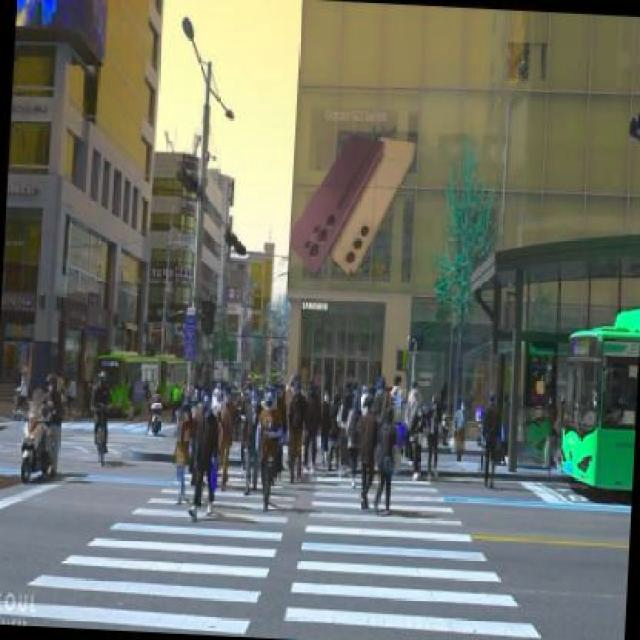

In [ ]:
image_path = "/content/roboflow/train/images/-4K-HDR-Back-to-Normal-Life-Hongdae-and-Yeonnam-dong-Cafe-Street-in-Seoul-Tour-Korea-Ambience-mp4_20221014_111352-729_jpg.rf.114bb2078e2e046e53bc9e4842d87b18.jpg"

result=model.predict(image_path)
result[0].plot()

In [ ]:
# TFLite 형식으로 내보내기
model.export(format="tflite")

Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (6.0 MB)
requirements: Ultralytics requirements ['ai-edge-litert>=1.2.0', 'protobuf>=5'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.2/316.2 kB 361.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3

requirements: AutoUpdate success ✅ 9.9s, installed 2 packages: ['ai-edge-litert>=1.2.0', 'protobuf>=5']
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


TensorFlow SavedModel: starting export with tensorflow 2.15.0...


100%|██████████| 1.11M/1.11M [00:00<00:00, 39.9MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 48.03file/s]


ONNX: starting export with onnx 1.16.0 opset 19...


ONNX: slimming with onnxslim 0.1.52...
ONNX: export success ✅ 1.7s, saved as 'runs/detect/train/weights/best.onnx' (11.8 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.27.4...
Saved artifact at 'runs/detect/train/weights/best_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 640, 640, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 8, 8400), dtype=tf.float32, name=None)
Captures:
  140454712428304: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  140454712428112: TensorSpec(shape=(3, 3, 3, 16), dtype=tf.float32, name=None)
  140454712428688: TensorSpec(shape=(16,), dtype=tf.float32, name=None)
  140454712431952: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  140454712431376: TensorSpec(shape=(3, 3, 16, 32), dtype=tf.float32, name=None)
  140454712432144: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  140454712430224: TensorSpec(shape=(1, 1, 

'runs/detect/train/weights/best_saved_model/best_float32.tflite'

Loading /content/runs/detect/train6/weights/best_saved_model/best_float32.tflite for TensorFlow Lite inference...

image 1/1 /content/roboflow/train/images/-4K-HDR-Back-to-Normal-Life-Hongdae-and-Yeonnam-dong-Cafe-Street-in-Seoul-Tour-Korea-Ambience-mp4_20221014_111342-332_jpg.rf.454742c7728ecc114891093d11a31d67.jpg: 640x640 1 crossWalk, 12 humans, 296.3ms
Speed: 4.2ms preprocess, 296.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
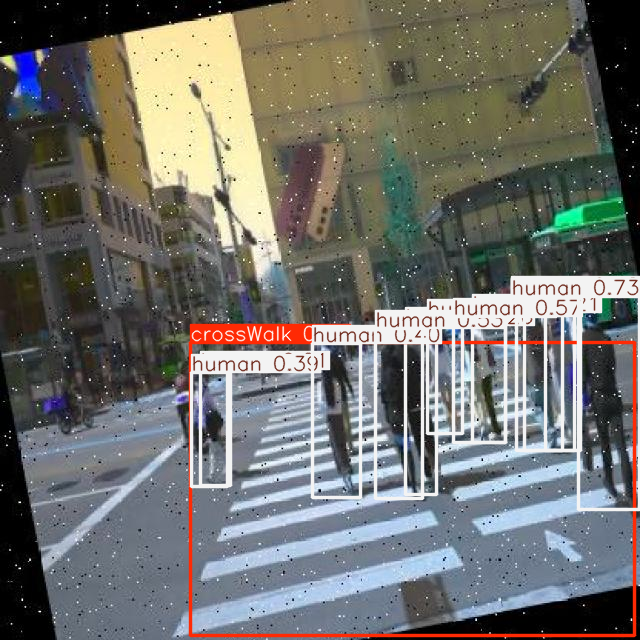

In [ ]:
model = YOLO("/content/runs/detect/train6/weights/best_saved_model/best_float32.tflite")

result = model.predict('/content/roboflow/train/images/-4K-HDR-Back-to-Normal-Life-Hongdae-and-Yeonnam-dong-Cafe-Street-in-Seoul-Tour-Korea-Ambience-mp4_20221014_111342-332_jpg.rf.454742c7728ecc114891093d11a31d67.jpg', save=True, imgsz=640, conf=0.2)

result[0].plot()

# Grad CAM

In [ ]:
# XAI : explainable ai

# xAI : 응용 ai

In [ ]:
# https://github.com/jacobgil/pytorch-grad-cam

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=793b86e81a7337eb387ca542805acba724d770dbffc9573aa97acffa1d2d1846
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # tqdm 추가
from torch.functional import F

# 1. 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_subset = Subset(train_dataset, indices=list(range(500)))  # 앞에서 500장만 사용

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# 2. CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # CNN 계층 정의
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 1채널 입력
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # 64x56x56 크기 이후에 128개 출력
        self.fc2 = nn.Linear(128, 10)  # 10개 클래스 (0~9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv -> ReLU -> Pooling
        x = x.view(-1, 64 * 56 * 56)  # 평탄화
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # 출력 레이어
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN()
model = model.to(device)

# 3. 학습 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 1
# 4. 학습 루프
model.train()
for epoch in range(epochs):
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

# 5. Grad-CAM 시각화
model.eval()

# 테스트 이미지 하나 가져오기
image_tensor, label = next(iter(test_loader))
input_tensor = image_tensor.to(device)

# 모델 예측
output = model(input_tensor)
target_class = output.argmax(dim=1).item()
targets = [ClassifierOutputTarget(target_class)]
targets

Epoch 1/1: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, loss=2.21]


In [ ]:
target_class

3

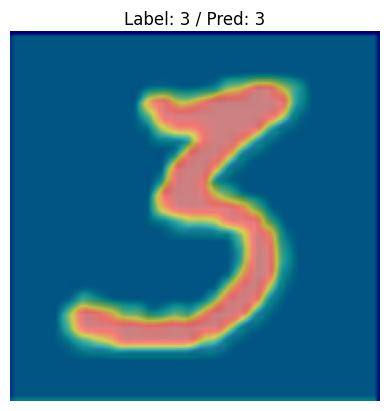

In [ ]:

# Grad-CAM 대상 레이어
target_layers = [model.conv2]  # 마지막 Conv 레이어로 설정

# Grad-CAM 계산
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0] # 첫번째 이미지 shape

# 입력 이미지 시각화용 전처리 (gradcam은 3채널 요구, grayscale → 3채널)
gray_img = image_tensor.squeeze().cpu().numpy()  # (224, 224)
rgb_img = np.stack([gray_img]*3, axis=-1)        # (224, 224, 3)
rgb_img = np.clip(rgb_img, 0, 1)

# Grad-CAM 이미지 생성
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# 출력
plt.imshow(visualization)
plt.title(f"Label: {label.item()} / Pred: {target_class}")
plt.axis('off')
plt.show()


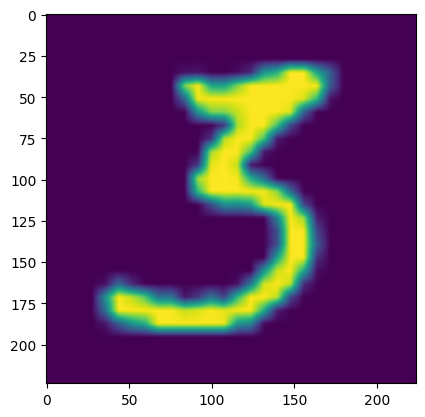

In [ ]:
# 원본이미지 시각화
plt.imshow(input_tensor[0][0].to('cpu'))